In [1]:
import matplotlib.pyplot as plt
import openfermion as of
from Hubbard_Model_nnn import *
import jax.numpy as jnp
from itertools import product
from jax import config
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy.sparse as sp
import glob
config.update("jax_enable_x64", True)

# Set parameters.

In [2]:
# Parameters.
x_dimension = 3
y_dimension = 3
n_up = 2
n_down = 2

n_site = x_dimension * y_dimension

U = 1
t = 1.0
t_prime = 0.3
mu = 0.0

## Construct the reduced Hamiltonian.

In [3]:
def reduced_hubbard_model(U, indices):
    hopping_terms = fermi_hubbard_nnn(x_dimension, y_dimension, tunneling=t, nnn_tunneling=t_prime, coulomb=U, chemical_potential=mu, periodic=True)
    hopping_terms = of.get_sparse_operator(hopping_terms)
    H_hubbard = hopping_terms[jnp.ix_(indices, indices)].toarray()

    return H_hubbard

In [4]:
valid_indices = []
for bits in product('01', repeat= 2 * x_dimension * y_dimension):

    spin_up_indices = bits[::2]
    spin_down_indices = bits[1::2]

    if spin_up_indices.count('1') == n_up and spin_down_indices.count('1') == n_down:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))

reduced_H_indices = jnp.array(valid_indices)

H_reduced = reduced_hubbard_model(U=U, indices=reduced_H_indices)
reduced_dim = len(H_reduced)
print('reduced_dim =', reduced_dim)

H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
print(f"Eigenvalues:", jnp.round(H_reduced_eigvals[:8], 3))

reduced_dim = 1296
Eigenvalues: [-10.897 -10.893 -10.893 -10.893 -10.893 -10.892 -10.892 -10.809]


In [5]:
U_sweep_ED = jnp.linspace(0, U, 80)

H_eigvals_sweep = []

for UU in U_sweep_ED:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

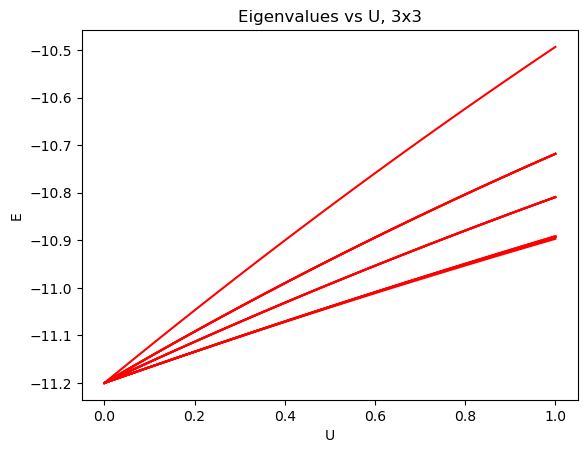

In [30]:
for band in range(16):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')


plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

# Schur complement

In [14]:
def find_degeneracies(E0, tol=1E-10):

    sorted_indices = jnp.argsort(E0)
    sorted_E0 = jnp.array(E0)[sorted_indices]
    
    degeneracy_counts = []

    current_degeneracy = 1

    for i in range(1, len(sorted_E0)):
        if jnp.abs(sorted_E0[i] - sorted_E0[i - 1]) < tol:

            current_degeneracy += 1
        else:

            degeneracy_counts.append(current_degeneracy)
            current_degeneracy = 1

    degeneracy_counts.append(current_degeneracy)
    
    return degeneracy_counts

def degenerate_states(Hi, H0_eigvecs, degeneracy_counts):

    start_index = 0
    for i, count in enumerate(degeneracy_counts):
        
        P = H0_eigvecs[:, start_index:start_index+count]
        P_T = jnp.conj(P.T)
        Hi_proj = P_T @ Hi @ P

        Hi_eigvals, Hi_eigvecs = jnp.linalg.eigh(Hi_proj)
        Hi_eigvecs = P @ Hi_eigvecs
        
        if i == 0:
            print("Eigenvalues of first Hi: \n", Hi_eigvals)
        
        H0_eigvecs = H0_eigvecs.at[:, start_index:start_index + count].set(Hi_eigvecs)
        start_index += count

    return H0_eigvecs

In [15]:
H0 =  reduced_hubbard_model(U=0, indices=reduced_H_indices)

H0_eigvals, H0_eigvecs = jnp.linalg.eigh(H0)
print("Eigenvalues of H0: \n", jnp.round(H0_eigvals[:8], 3))

Hi = reduced_hubbard_model(U=1, indices=reduced_H_indices) - H0

Eigenvalues of H0: 
 [-11.2 -11.2 -11.2 -11.2 -11.2 -11.2 -11.2 -11.2]


In [ ]:
degeneracy_counts = find_degeneracies(H0_eigvals[:], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
k = sum(degeneracy_counts[:1])

degeneracy_counts = find_degeneracies(H0_eigvals[:k], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
H0_eigvecs_updated = degenerate_states(Hi, H0_eigvecs[:, :k], degeneracy_counts)
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

Number of degerate Eigenvalues:
 [16, 32, 16, 48, 176, 176, 36, 48, 192, 328, 192, 36]
Number of degerate Eigenvalues:
 [16]
Eigenvalues of first Hi: 
 [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.44444444 0.44444444 0.44444444 0.44444444 0.55555556
 0.55555556 0.55555556 0.55555556 0.77777778]


In [50]:
k = 7
H0_eigvecs_updated = H0_eigvecs_updated[:, :k]
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

In [43]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = jnp.linalg.inv(M)

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [44]:
def Schur_complement_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    N = jnp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = jnp.linalg.eigh(M)
    M_eigvals_inv = jnp.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ jnp.conj(M_eigvecs.T) * 2 * kappa / N

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [45]:
def QHQ_spectrum(H, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    QHQ = Q @ H @ Q

    spectrum = jnp.linalg.eigh(QHQ)

    return spectrum

In [46]:
QHQ_eigvals, QHQ_eigvecs = QHQ_spectrum(H=H_reduced, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)

## Eigenbranches (error $ = 10^{-3}$)

In [47]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [48]:
Xlim = [H_reduced_eigvals[0] - 0.1, H_reduced_eigvals[10] + 0.1]
N_plot = 100
Energy = jnp.linspace(Xlim[0], Xlim[1], N_plot)

In [51]:
Eigenbranches = []
for En in Energy:
    Schur = Schur_complement_qsp(H=H_reduced, E=En, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa)
    sub_eigvals = jnp.linalg.eigvalsh(Schur)
    Eigenbranches.append(sub_eigvals)
Eigenbranches = jnp.array(Eigenbranches).T

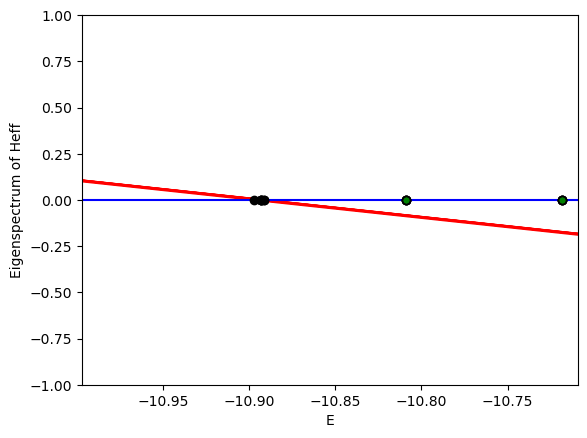

In [52]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(4, 7)
plt.ylim(-1, 1)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

plt.axhline(y=0, color='blue')

plt.plot(H_reduced_eigvals, jnp.zeros_like(H_reduced_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, jnp.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

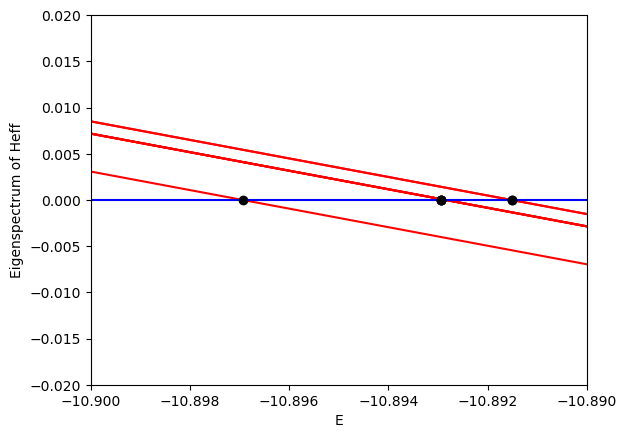

In [103]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(-10.9, -10.89)
# plt.xlim(4, 7)
plt.ylim(-0.02, 0.02)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

plt.axhline(y=0, color='blue')

plt.plot(H_reduced_eigvals, jnp.zeros_like(H_reduced_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, jnp.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

# Binary search 
### ($\Delta U = 0.1$)

## error $ = 10^{-3}$

In [53]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [54]:
U_sweep = jnp.linspace(0, U, 11)

In [55]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 5 iterations.
-11.167510183251188
Converged in 5 iterations.
-11.167456144685787
Converged in 5 iterations.
-11.167456144685772
Converged in 5 iterations.
-11.167456144685769
Converged in 5 iterations.
-11.167456144685751
Converged in 5 iterations.
-11.167441901474012
Converged in 5 iterations.
-11.167441901474005
solve: 2
Converged in 5 iterations.
-11.135146151132314
Converged in 5 iterations.
-11.134936286749394
Converged in 5 iterations.
-11.13493628674938
Converged in 5 iterations.
-11.134936286749376
Converged in 5 iterations.
-11.134936286749358
Converged in 5 iterations.
-11.134879577357204
Converged in 5 iterations.
-11.134879577357193
solve: 3
Converged in 5 iterations.
-11.10340021349691
Converged in 5 iterations.
-11.1029420548797
Converged in 5 iterations.
-11.102942054879684
Converged in 5 iterations.
-11.10294205487968
Converged in 5 iterations.
-11.102942054879664
Converged in 5 iterations.
-11.10281519625489
Converged in 5 iterations.
-11.10281519

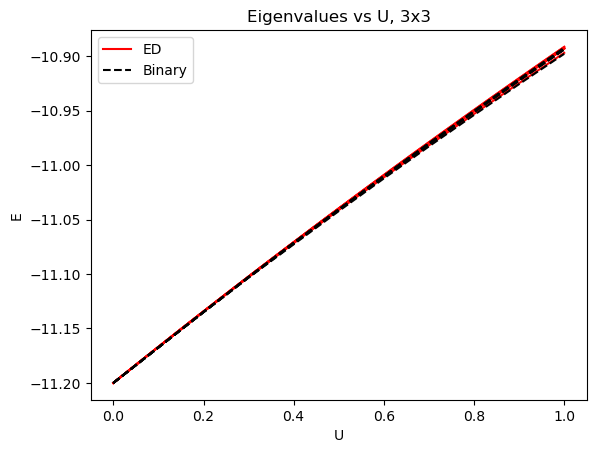

In [57]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [59]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-0.0008976978622730059
-0.0008223825408304464
-0.0008223825408180119
-0.0008223825408126828
-0.0008223825408002483
-0.0009281645762264645
-0.0009281645762193591


## error $ = 10^{-6}$

In [60]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [61]:
U_sweep = jnp.linspace(0, U, 11)

In [62]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 15 iterations.
-11.166995161924099
Converged in 15 iterations.
-11.166941085013296
Converged in 15 iterations.
-11.16694108501328
Converged in 15 iterations.
-11.166941085013278
Converged in 15 iterations.
-11.166941085013258
Converged in 15 iterations.
-11.166925593581254
Converged in 15 iterations.
-11.166925593581247
solve: 2
Converged in 14 iterations.
-11.134634154765909
Converged in 14 iterations.
-11.134425034070981
Converged in 14 iterations.
-11.134425034070967
Converged in 14 iterations.
-11.134425034070961
Converged in 14 iterations.
-11.134425034070945
Converged in 14 iterations.
-11.13436363297568
Converged in 14 iterations.
-11.134363632975669
solve: 3
Converged in 14 iterations.
-11.102898793786718
Converged in 14 iterations.
-11.102443881064545
Converged in 14 iterations.
-11.10244388106453
Converged in 14 iterations.
-11.102443881064525
Converged in 14 iterations.
-11.10244388106451
Converged in 14 iterations.
-11.102307009230854
Converged in 14 i

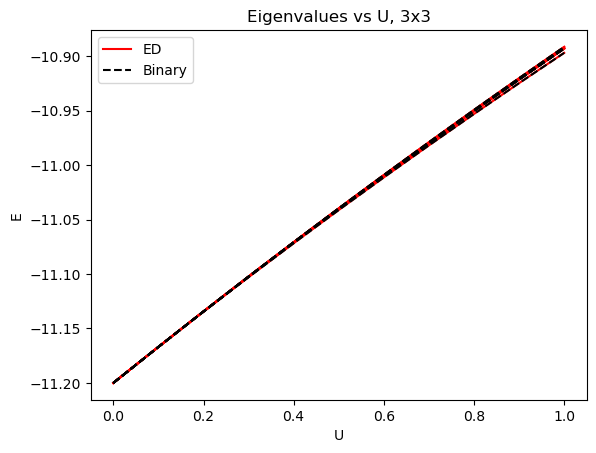

In [63]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [64]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-7.284157312881234e-07
3.8169548961519695e-06
3.8169549068101105e-06
3.816954913915538e-06
3.816954926350036e-06
-7.520571987384983e-07
-7.520571898567141e-07


## error $ = 10^{-8}$

In [65]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [66]:
U_sweep = jnp.linspace(0, U, 11)

In [67]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 21 iterations.
-11.166994667144195
Converged in 21 iterations.
-11.166940583444045
Converged in 21 iterations.
-11.166940583444031
Converged in 21 iterations.
-11.166940583444028
Converged in 21 iterations.
-11.16694058344401
Converged in 21 iterations.
-11.166925097515131
Converged in 21 iterations.
-11.166925097515122
solve: 2
Converged in 21 iterations.
-11.134633180222483
Converged in 21 iterations.
-11.134424023579186
Converged in 21 iterations.
-11.134424023579172
Converged in 21 iterations.
-11.134424023579164
Converged in 21 iterations.
-11.13442402357915
Converged in 21 iterations.
-11.134362650781764
Converged in 21 iterations.
-11.134362650781753
solve: 3
Converged in 21 iterations.
-11.102897845279308
Converged in 21 iterations.
-11.102442830600271
Converged in 21 iterations.
-11.102442830600257
Converged in 21 iterations.
-11.10244283060025
Converged in 21 iterations.
-11.102442830600236
Converged in 21 iterations.
-11.102306046826989
Converged in 21 

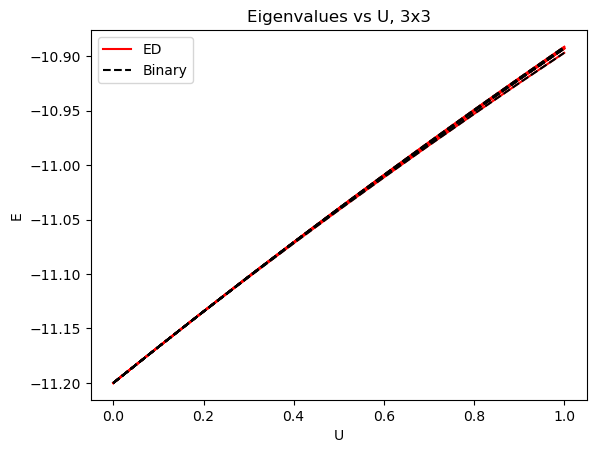

In [68]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [69]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-5.667835978329094e-09
9.386645958286977e-06
9.386645972497831e-06
9.386645976050545e-06
9.386645988485043e-06
8.757175073981216e-08
8.757175962159636e-08


## $\Delta U = 1$

## error $ = 10^{-3}$

In [70]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [71]:
U_sweep = jnp.linspace(0, U, 2)

In [72]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 8 iterations.
-10.897513146282389
Converged in 8 iterations.
-10.89343253525116
Converged in 8 iterations.
-10.893432535251145
Converged in 8 iterations.
-10.89343253525114
Converged in 8 iterations.
-10.893432535251126
Converged in 8 iterations.
-10.8921103139043
Converged in 8 iterations.
-10.892110313904293


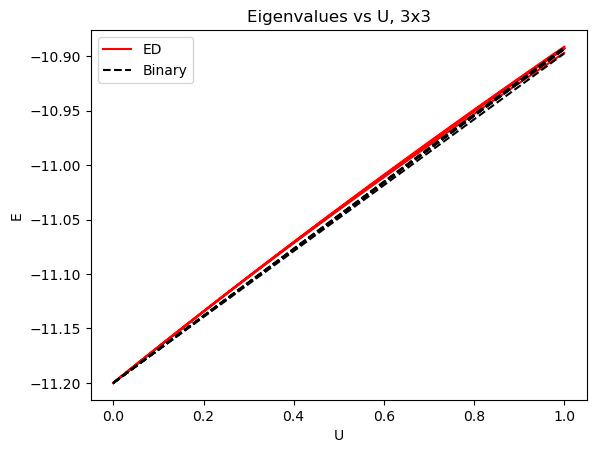

In [73]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [74]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-0.0005903076072151237
-0.0005017096323811643
-0.0005017096323669534
-0.0005017096323616244
-0.0005017096323491899
-0.000602589047606017
-0.0006025890475989115


# Wegstien's method
### ($\Delta U = 0.1$)

## error $ = 10^{-3}$

In [75]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [76]:
U_sweep = jnp.linspace(0, U, 11)

In [77]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 1 iterations.
-11.166994603188009
Converged in 1 iterations.
-11.166939686813787
Converged in 1 iterations.
-11.166939686813771
Converged in 1 iterations.
-11.166939686813768
Converged in 1 iterations.
-11.16693968681375
Converged in 1 iterations.
-11.1669252069203
Converged in 1 iterations.
-11.166925206920293
solve: 2
Converged in 1 iterations.
-11.134632948439037
Converged in 1 iterations.
-11.134420539088046
Converged in 1 iterations.
-11.13442053908803
Converged in 1 iterations.
-11.134420539088024
Converged in 1 iterations.
-11.134420539088008
Converged in 1 iterations.
-11.134363113890421
Converged in 1 iterations.
-11.13436311389041
solve: 3
Converged in 1 iterations.
-11.102897416121246
Converged in 1 iterations.
-11.102435175782594
Converged in 1 iterations.
-11.102435175782578
Converged in 1 iterations.
-11.102435175782574
Converged in 1 iterations.
-11.102435175782558
Converged in 1 iterations.
-11.1023071127734
Converged in 1 iterations.
-11.102307112

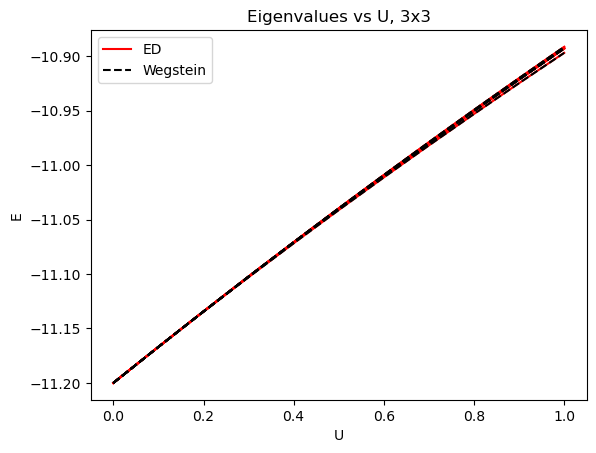

In [78]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [79]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-1.6645395058745294e-05
8.102560818912252e-05
8.102560820333338e-05
8.102560820510973e-05
8.102560821932059e-05
-1.5693995253585058e-05
-1.5693995244703274e-05


## error $ = 10^{-6}$

In [80]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [81]:
U_sweep = jnp.linspace(0, U, 11)

In [82]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-11.166994658637899
Converged in 2 iterations.
-11.1669405808673
Converged in 2 iterations.
-11.16694058086657
Converged in 2 iterations.
-11.166940580866644
Converged in 2 iterations.
-11.166940580866248
Converged in 2 iterations.
-11.16692508915478
Converged in 2 iterations.
-11.166925089155187
solve: 2
Converged in 2 iterations.
-11.1346331695717
Converged in 2 iterations.
-11.134424043919832
Converged in 2 iterations.
-11.134424043919797
Converged in 2 iterations.
-11.134424043920593
Converged in 2 iterations.
-11.134424043920417
Converged in 2 iterations.
-11.134362641111487
Converged in 2 iterations.
-11.134362641111366
solve: 3
Converged in 2 iterations.
-11.102897830488168
Converged in 2 iterations.
-11.102442909843743
Converged in 2 iterations.
-11.10244290984389
Converged in 2 iterations.
-11.10244290984357
Converged in 2 iterations.
-11.102442909843635
Converged in 2 iterations.
-11.102306035029734
Converged in 2 iterations.
-11.1023060350

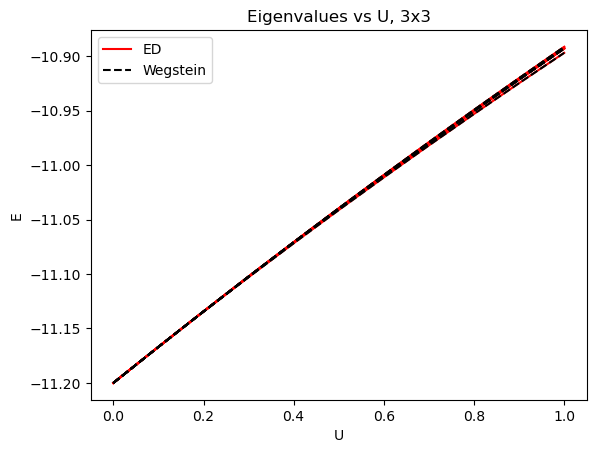

In [83]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [84]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

7.63637153511354e-08
4.641832800800216e-06
4.641832962448689e-06
4.6418326000718935e-06
4.641833703189491e-06
8.625874059475791e-08
8.625995562283606e-08


## error $ = 10^{-8}$

In [85]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [86]:
U_sweep = jnp.linspace(0, U, 11)

In [87]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-11.166994659282537
Converged in 5 iterations.
-11.166940575568606
Converged in 2 iterations.
-11.166940575568587
Converged in 2 iterations.
-11.166940575568493
Converged in 11 iterations.
-11.166940575571418
Converged in 44 iterations.
-11.166925089634734
Converged in 10 iterations.
-11.166925089636884
solve: 2
Converged in 2 iterations.
-11.134633172534526
Converged in 2 iterations.
-11.134424015852083
Converged in 2 iterations.
-11.134424015851724
Converged in 2 iterations.
-11.134424015850762
Converged in 2 iterations.
-11.134424015851593
Converged in 2 iterations.
-11.134362643039783
Converged in 2 iterations.
-11.134362643039086
solve: 3
Converged in 2 iterations.
-11.102897837771964
Converged in 2 iterations.
-11.10244282303039
Converged in 2 iterations.
-11.102442823029923
Converged in 2 iterations.
-11.102442823029662
Converged in 2 iterations.
-11.102442823029888
Converged in 2 iterations.
-11.102306039230456
Converged in 2 iterations.
-11.

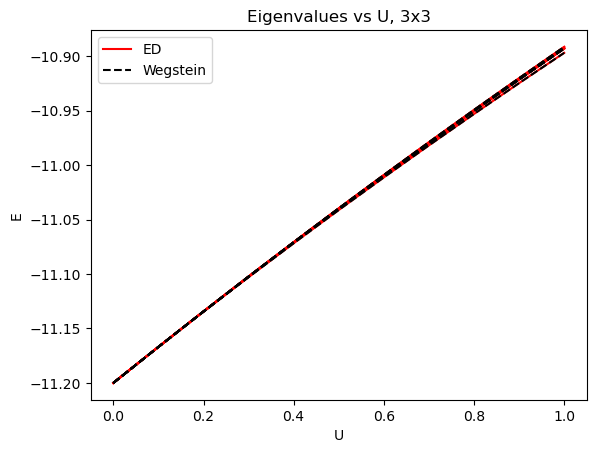

In [88]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [89]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

4.672315867537691e-10
9.392940270913641e-06
9.39293977708644e-06
9.392939793073651e-06
9.39294002400004e-06
9.398758216150327e-08
9.398851474884395e-08


## $\Delta U = 1$

## error $ = 10^{-3}$

In [90]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [91]:
U_sweep = jnp.linspace(0, U, 2)

In [92]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-10.896939484074297
Converged in 1 iterations.
-10.892849799664624
Converged in 1 iterations.
-10.89284979966461
Converged in 1 iterations.
-10.892849799664605
Converged in 1 iterations.
-10.89284979966459
Converged in 1 iterations.
-10.891523418575487
Converged in 1 iterations.
-10.891523418575476


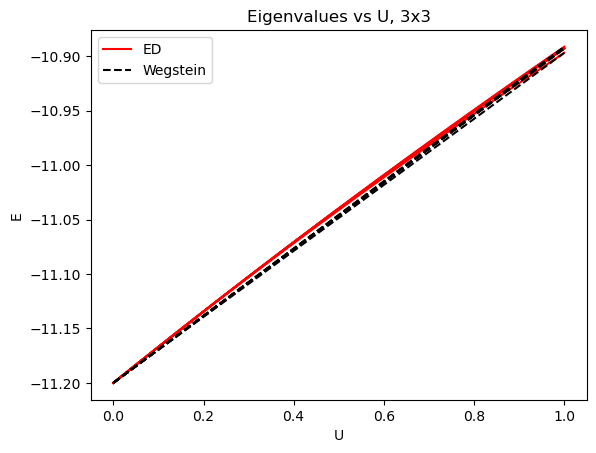

In [93]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [94]:
for i in range(7):
    print(solved_eigvals.T[-1, i]-H_eigvals_sweep.T[-1, i])

-1.6645399123049742e-05
8.102595415415692e-05
8.102595416836778e-05
8.102595417369685e-05
8.102595418613134e-05
-1.5693718792064715e-05
-1.5693718781406574e-05
